# Лабораторная работа №8
## ПРОГНОЗИРОВАНИЕ ВРЕМЕННЫХ РЯДОВ
### Комлева Юлия Владимировна
### Вариант: 9
### Группа: РИМ-181226

In [74]:
import numpy as np
import matplotlib.pyplot as plt
import h5py
import scipy.stats as stats
from statsmodels.tsa import api as tsa
from statsmodels.tsa.arima_model import ARIMA
%matplotlib inline

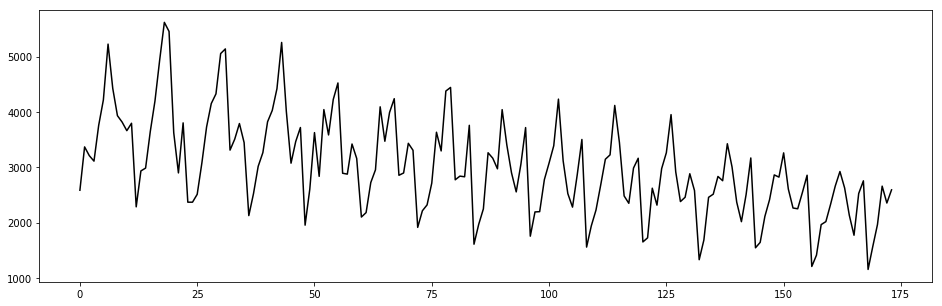

In [75]:
file = h5py.File('Fort.mat', 'r')
data = np.array(file.get('Fort'))
Fort = np.array(data)
plt.figure(figsize = (16, 5))
plt.plot(data, 'k')
plt.show()

На глаз, в ряде видна явная
сезонность, присутствует некоторый убывающий тренд. Был выбран
короткий ряд, чтобы повысить скорость расчетов.

Мы будем производить __ретроспективный прогноз__, то есть у нас
всегда будут точки, по которым можно будет сравнить, правильным
получился прогноз, или нет. Для этого отрежем от данного ряда
последние 24 точки (которые мы и будем прогнозировать):

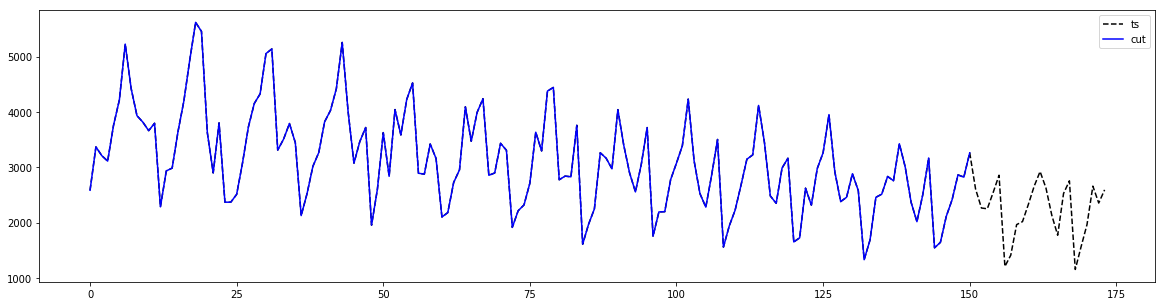

In [76]:
Z = Fort[:len(Fort)-24+1] # отрезаем последние 24 точки
t = np.arange(0, len(Z), 1) # временная шкала для регрессии

plt.figure(figsize = (20, 5))
plt.plot(Fort, 'k--', label = 'ts') # исходный ВР
plt.plot(t, Z, 'b', label = 'cut') # урезанный ряд
plt.legend()
plt.show()

## Оценки точности прогнозов
### Средняя ошибка прогноза
$$\overline{\Delta ^*}=\frac {\sum \limits_{i=1}^{M}\Delta ^*_i}{M}=\frac {\sum \limits_{i=1}^{M}|y(t_i)-y_i|}{M}$$


In [78]:
#MAE
def mean_absolute_error2(y_true, y_pred):
    M = len(y_pred)
    tmp = 0
    for i in range(M):
        tmp += np.abs(y_true[i]-y_pred[i])
    return tmp/M

In [79]:
from sklearn.metrics import mean_absolute_error
#mean_absolute_error(y_true, y_pred)

### СКВО прогноза
$$\sigma _e=\sqrt{\frac{\sum \limits_{i=1}^{M}\left( y(t_i)-y_i\right) ^2}{M}}$$


In [80]:
def root_mean_squared_error(y_true, y_pred):
    M = len(y_pred)
    tmp = 0
    for i in range(M):
        tmp += (y_true[i]-y_pred[i])**2
    return np.sqrt(tmp/len(y_pred))

In [82]:
from sklearn.metrics import mean_squared_error
#np.sqrt(mean_squared_error(y_true, y_pred))

### Средняя ошибка аппроксимации
$$\overline{\varepsilon }=\frac{1}{M}\sum \limits_{i=1}^{M}\frac{|y(t_i)-y_i|}{y(t_i)}\cdot 100\%$$

In [83]:
def mean_approximation_error(y_true,y_pred):
    M = len(y_pred)
    tmp = 0
    for i in range(M):
        tmp += np.abs(y_true[i] - y_pred[i]) / y_true[i]
    return tmp / M * 100

#### Коэффициент несоответствия 
##### Первая модификация:
$$KH_1=\sqrt{\frac{\sum \limits_{i=1}^{M}(y_i-y(t_i))^2}{\sum \limits_{i=1}^{M}y(t_i)^2}}$$
для которого: 
- если $KH_1=0$ то есть полное совпадение фактических $y(t_i)$ и прогнозных $y_i$ отсчетов; 
- если $KH_1=1$ то точность соотносима с простейшими методами экстраполяции ряда; 
- если $KH_1 > 1$ то такой прогноз дает результаты хуже, чем, если бы мы просто предполагали неизменность среднего значения ряда.
##### Вторая модификация:
$$KH_2=\sqrt{\frac{\sum \limits_{i=1}^{M}(y_i-y(t_i))^2}{\sum \limits_{i=1}^{M}(\overline{y}-y(t_i))^2}}$$
то есть представляет отношение средней квадратичной ошибки прогноза к сумме квадратов отклонений от среднего уровня за весь период прогноза.
##### Третья модификация:
$$KH_3=\sqrt{\frac{\sum \limits_{i=1}^{M}( y_i-y(t_i))^2}{\sum \limits_{i=1}^{M}(y(t_i)-\tau _i)^2}}$$
Этот коэффициент отражает отношение средней квадратичной ошибки прогноза к сумме квадратов отклонений фактических отсчетов от отсчетов прогноза по простому тренду. По сути, такой показатель отражает, насколько используемый прогноз лучше или хуже прогноза, который происходил просто на основе экстраполяции тренда исходного ряда.

In [84]:
def coef1(y_true, y_pred):
    M = len(y_pred)
    tmp = 0
    tmp2 = 0
    for i in range(M):
        tmp += (y_pred[i]-y_true[i])**2
        tmp2 += y_true[i]**2
    tmp = np.sqrt(tmp/tmp2)
    return tmp
   
def coef2(y_true, y_pred):
    M = len(y_pred)
    tmp = 0
    tmp2 = 0
    m = np.mean(y_true) #
    for i in range(M):
        tmp += (y_pred[i]-y_true[i])**2
        tmp2 += (m - y_true[i])**2
    return np.sqrt(tmp/tmp2)

In [100]:
def print_metrics(y_true_,y_pred_):
    metrics = []
    for metric in [mean_absolute_error, root_mean_squared_error, mean_approximation_error, coef1, coef2]:
        metrics.append(np.round(metric(y_true_.ravel(),y_pred_.ravel()), 3))
    return metrics

In [101]:
metrics_names = ['MAE__', 'RMSE_', 'appr_', 'coef1', 'coef2']

# Регрессионная модель тренда первого, второго и третьего порядка

In [102]:
from sklearn.linear_model import LinearRegression
import statsmodels.api as sm
from scipy.optimize import curve_fit

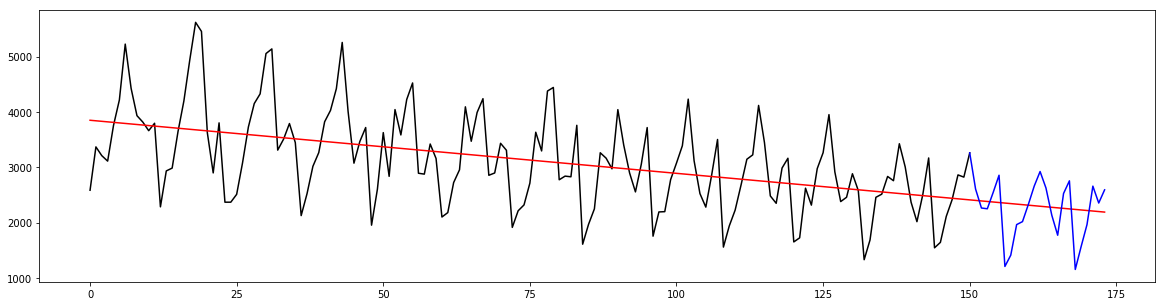

In [103]:
t = np.arange(0, len(Z), 1) # диапазон урезанного ряда
t0 = np.arange(0, len(Fort), 1) # диапазон полного ряда

X = list(zip(np.ones(len(t)), t))

Z = Fort[:len(Fort)-24+1] # отрезаем последние 24 точки
Y = np.hstack(Z)

#LinearRegression
reg = LinearRegression().fit(t.reshape(-1,1), Y) # модель регрессии

#statsmodels
x_ = sm.add_constant(t)
smm = sm.OLS(Y, x_)
res = smm.fit() # строим модель регрессии

#polyfit
bb = np.polyfit(t, Y, 1)
p = np.poly1d(bb) # создаем экземпляр полинома

#curvefit
def func(t, b0, b1):
    return b0 + b1 * t
popt, pcov = curve_fit(func, t, Y)

plt.figure(figsize = (20, 5))
plt.plot(t, Y, 'k')
plt.plot(t0, reg.predict(t0.reshape(-1,1)), 'r') # прогноз на весь диапазон
plt.plot(t0[-24:], Fort[-24:], 'b') # реальные прогнозные значения
plt.show()

#metrics
m_lr_1 = print_metrics(Fort[-24:], reg.predict(t0[-24:].reshape(-1,1)))
m_sm_1 = print_metrics(Fort[-24:], res.predict(sm.add_constant(t0[-24:])))
m_pf_1 = print_metrics(Fort[-24:], p(t0[-24:]))
m_cf_1 = print_metrics(Fort[-24:], func(t0[-24:],popt[0],popt[1]))

In [104]:
m_lr_1 == m_sm_1 == m_pf_1 == m_cf_1

True

In [105]:
list(zip(metrics_names, m_lr_1))

[('MAE__', 437.017),
 ('RMSE_', 531.284),
 ('appr_', 23.514),
 ('coef1', 0.228),
 ('coef2', 0.991)]

# 2

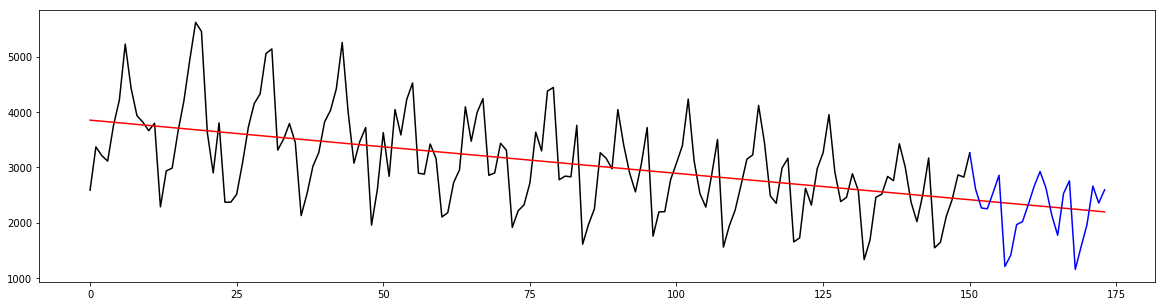

In [117]:
XX = list(zip(np.ones(len(t)), t, t**2))
XX0 = list(zip(np.ones(len(t0)), t0, t0**2))

#LinearRegression
reg = LinearRegression().fit(XX, Y) # модель регрессии

#statsmodels
x_ = sm.add_constant(XX)
smm = sm.OLS(Y, x_)
res = smm.fit() # строим модель регрессии

#polyfit
bb = np.polyfit(t, Y, 2)
p = np.poly1d(bb) # создаем экземпляр полинома

#curvefit
def func2(t, b0, b1, b2):
    return b0 + b1 * t + b2 * t * t

popt, pcov = curve_fit(func2, t, Y)


plt.figure(figsize = (20, 5))
plt.plot(t, Y, 'k')
plt.plot(t0, reg.predict(XX0), 'r') # прогноз на весь диапазон
plt.plot(t0[-24:], Fort[-24:], 'b') # реальные прогнозные значения
plt.show()

#metrics
m_lr_2 = print_metrics(Fort[-24:], reg.predict(XX0[-24:]))
m_sm_2 = print_metrics(Fort[-24:], res.predict(sm.add_constant(XX0[-24:])))
m_pf_2 = print_metrics(Fort[-24:], p(t0[-24:]))
m_cf_2 = print_metrics(Fort[-24:], func2(t0[-24:],popt[0],popt[1], popt[2]))

In [118]:
m_lr_2 == m_sm_2 == m_pf_2 == m_cf_2

True

In [119]:
list(zip(metrics_names, m_lr_2))

[('MAE__', 436.699),
 ('RMSE_', 531.514),
 ('appr_', 23.533),
 ('coef1', 0.228),
 ('coef2', 0.991)]

### 3

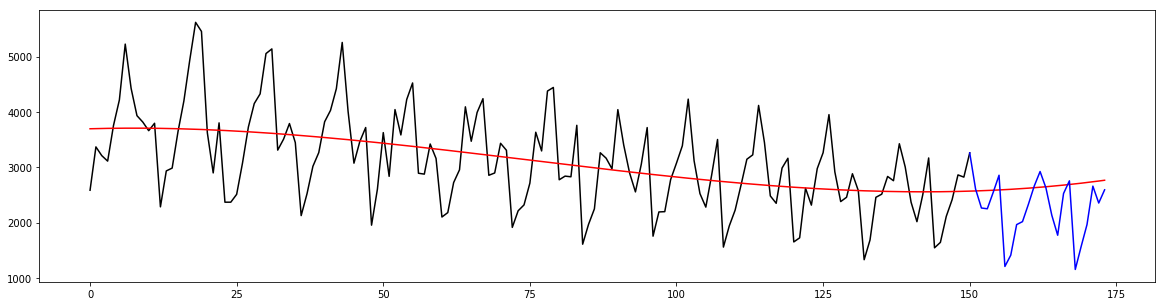

In [120]:
XXX = list(zip(np.ones(len(t)), t, t**2, t**3))
XXX0 = list(zip(np.ones(len(t0)), t0, t0**2, t0**3))

#LinearRegression
reg = LinearRegression().fit(XXX, Y) # модель регрессии

#statsmodels
x_ = sm.add_constant(XXX)
smm = sm.OLS(Y, x_)
res = smm.fit() # строим модель регрессии

#polyfit
bb = np.polyfit(t, Y, 3)
p = np.poly1d(bb) # создаем экземпляр полинома

#curvefit
def func3(t, b0, b1, b2, b3):
    return b0 + b1 * t + b2 * t * t + b3 * t * t * t

popt, pcov = curve_fit(func3, t, Y)


plt.figure(figsize = (20, 5))
plt.plot(t, Y, 'k')
plt.plot(t0, reg.predict(XXX0), 'r') # прогноз на весь диапазон
plt.plot(t0[-24:], Fort[-24:], 'b') # реальные прогнозные значения
plt.show()

#metrics
m_lr_3 = print_metrics(Fort[-24:], reg.predict(XXX0[-24:]))
m_sm_3 = print_metrics(Fort[-24:], res.predict(sm.add_constant(XXX0[-24:])))
m_pf_3 = print_metrics(Fort[-24:], p(t0[-24:]))
m_cf_3 = print_metrics(Fort[-24:], func3(t0[-24:],popt[0],popt[1], popt[2], popt[3]))

In [121]:
m_lr_3 == m_sm_3 == m_pf_3 == m_cf_3

True

In [122]:
list(zip(metrics_names, m_lr_3))

[('MAE__', 494.113),
 ('RMSE_', 665.008),
 ('appr_', 29.305),
 ('coef1', 0.286),
 ('coef2', 1.24)]

In [123]:
list(zip(metrics_names, m_lr_1, m_lr_2, m_lr_3))

[('MAE__', 437.017, 436.699, 494.113),
 ('RMSE_', 531.284, 531.514, 665.008),
 ('appr_', 23.514, 23.533, 29.305),
 ('coef1', 0.228, 0.228, 0.286),
 ('coef2', 0.991, 0.991, 1.24)]

# Доверительные интервалы
Постройте доверительные интервалы для тренда первого порядка
на рисунке вместе с прогнозом и самим рядом по следующей
методике:
$$\begin{matrix} \tau _B(t)=\tau (t)+\delta (t), \\ \tau _H(t)=\tau (t)-\delta (t)\end{matrix} $$
где $\tau (t)$ – оценка прогноза тренда, $\tau _B(t)$ – верхняя граница доверительного интервала, $\tau _H(t)$ – нижняя граница доверительного интервала.
$$\delta _{p=1}(t_1)=t_{\alpha ,N-2}\cdot S\cdot \sqrt {1+\frac {1}{N}+\frac{\left( \tau (t_1)-\overline{\tau }\right) ^2}{\sum \limits_{i=1}^{N}(\tau _i-\overline{\tau })^2}} = 1.96\cdot S\cdot \sqrt {1+\frac {1}{N}+\frac{\left( \tau (t_1)-\overline{\tau }\right) ^2}{\sum \limits_{i=1}^{N}(\tau _i-\overline{\tau })^2}}$$
где $S=\sqrt{\frac {\sum \limits_{i=1}^{N}e^2_i}{N-2}},$ $e_i$– остаточный ряд или ряд ошибок, то есть разница между исходным ВР и его прогнозом.

$t_{\alpha ,N-2}$ – квантиль распределения Стьюдента для доверительной вероятности  со степенями свободы  Значение квантиля находится по таблицам, либо с помощью специальных функций математических и других расчетных пакетов.

$P=0.95, n=inf$

In [129]:
popt, pcov = curve_fit(func, t, Y)

In [133]:
def delta(y_true, y_pred):
    N = len(y_true)
    S = 0
    for i in range (N):
        S += (y_true[i]-y_pred[i])**2
    S = np.sqrt(S/(N-2))
    tmp = (y_pred[i] - np.mean(y_true))**2
    tmp2 = 0
    for i in range(N):
        tmp2 += (y_true[i] - np.mean(y_true))**2
    tmp = tmp / tmp2
    tmp = np.sqrt(1 + 1/N + tmp) * S * 1.96

    return tmp

In [134]:
confint_up = func(t0,popt[0],popt[1]) + delta(Fort, func(t0, popt[0], popt[1]))
confint_down = func(t0,popt[0],popt[1]) - delta(Fort, func(t0, popt[0], popt[1]))

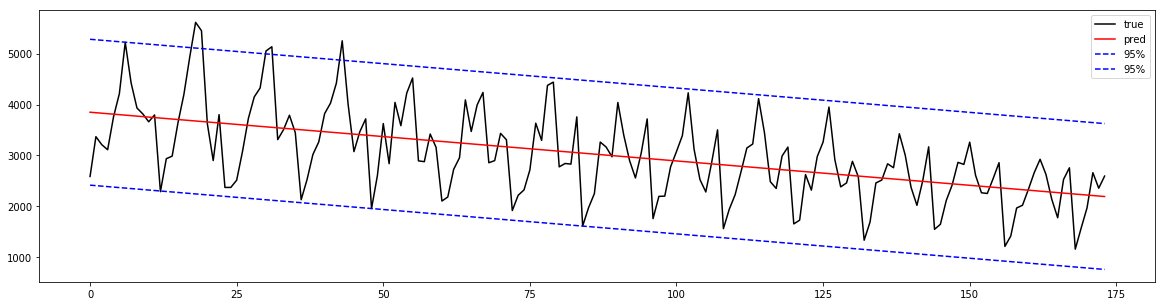

In [135]:
plt.figure(figsize = (20, 5))
plt.plot(t0, Fort, 'k', label='true')
plt.plot(t0, func(t0, *popt), 'r', label='pred')
plt.plot(t0, confint_up, 'b--',label='95%')
plt.plot(t0, confint_down, 'b--',label='95%')
plt.legend()
plt.show()

In [139]:
def delta2(y_true, y_pred):
    return 1.96* root_mean_squared_error(y_true, y_pred)

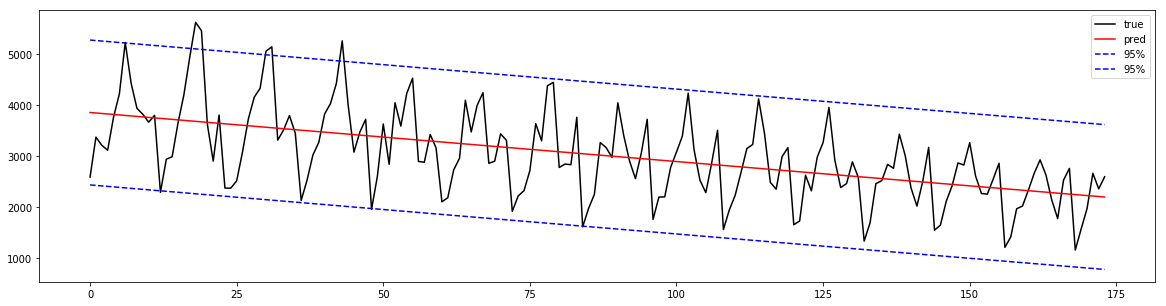

In [143]:
popt, pcov = curve_fit(func2, t, Y)

confint_up = func2(t0,*popt) + delta2(Fort, func2(t0,*popt))
confint_down=func2(t0,*popt) - delta2(Fort, func2(t0,*popt))

plt.figure(figsize = (20, 5))
plt.plot(t0, Fort, 'k', label='true')
plt.plot(t0, func2(t0,*popt), 'r', label='pred')
plt.plot(t0, confint_up, 'b--',label='95%')
plt.plot(t0, confint_down, 'b--',label='95%')
plt.legend()
plt.show()

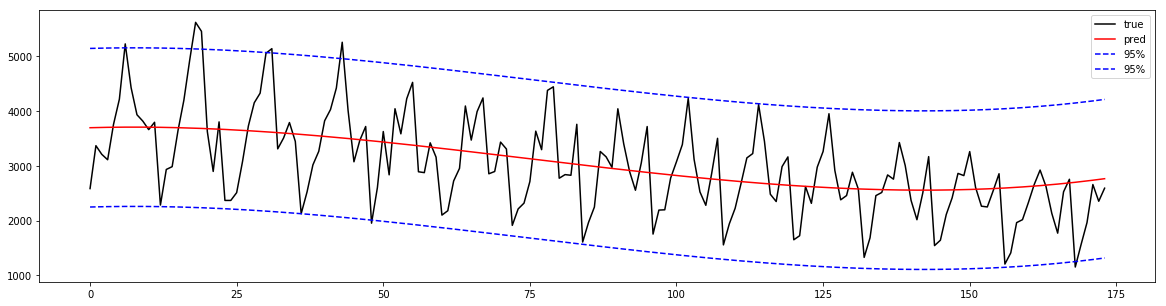

In [142]:
popt, pcov = curve_fit(func3, t, Y)

confint_up=func3(t0,*popt) + delta2(Fort, func3(t0,*popt))
confint_down=func3(t0,*popt) - delta2(Fort, func3(t0,*popt))
plt.figure(figsize = (20, 5))
plt.plot(t0, Fort, 'k', label='true')
plt.plot(t0, func3(t0,*popt), 'r', label='pred')
plt.plot(t0, confint_up, 'b--',label='95%')
plt.plot(t0, confint_down, 'b--',label='95%')
plt.legend()
plt.show()

Метод построения регрессионной кривой через подгонку
функций библиотеки scipy.optimize позволяет по МНК задавать
любую форму кривой. Попробуйте самостоятельно задать некоторую
параметрическую кривую, которая давала бы более высокую
точность, нежели простые линейные регрессионные кривые. Оцените
ее точность аналогично и постройте эмпирические оценки
доверительных интервалов.

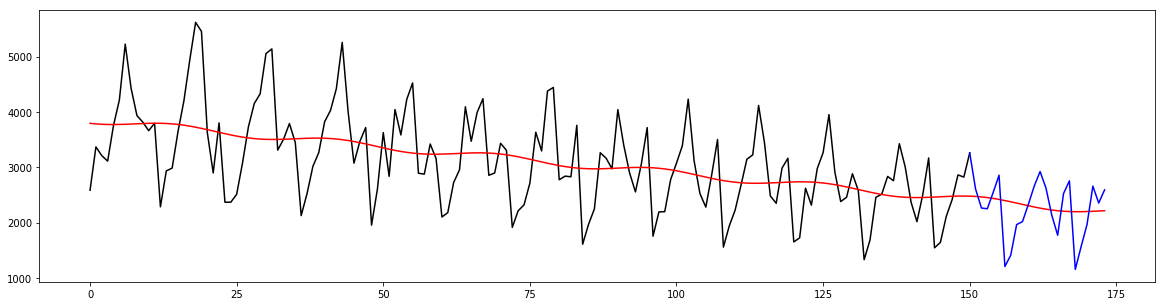

[435.871, 530.789, 23.482, 0.228, 0.99]


In [148]:
def funcls(t, a, b, c, d, e, f, g, h, j):
    return a + b*t + c*t*t + d*np.cos(e*t + f)

from scipy.optimize import curve_fit
popt, pcov = curve_fit(funcls, t, Y)
plt.figure(figsize = (20, 5))
plt.plot(t, Z, 'k')
plt.plot(t0, funcls(t0,*popt), 'r')
plt.plot(t0[-24:], Fort[-24:], 'b')
plt.show()

m = print_metrics(Fort[-24:], funcls(t0[-24:],*popt))
print(m)
#print(m_lr_1)
#print(m_lr_2)
#print(m_lr_3)

# ARIMA
Теперь обратимся к прогнозированию на основе АРПСС моделей.
Но прежде, чем строить такую модель, обратите внимание: модели
АРПСС строятся для рядов с около-нулевым средним, что неверно
для заданного временного ряда. 

Поэтому – сначала постройте
__линейный тренд__ прогнозируемого ряда (см. линейную регрессию
первого порядка выше), а затем вычтите его из исходного ряда,
приведя его к нулевому среднему значению (к так называемой __трендстационарной форме__). 
## Трендстационарная форма 

In [42]:
def func(t, b0, b1):
    return b0 + b1 * t

popt, pcov = curve_fit(func, t, Y)

Y_trend_stat = Y - func(t, popt[0], popt[1])

In [149]:
import warnings
warnings.filterwarnings("ignore")

In [179]:
def find_order_BIC(YY):
    p_values = range(0,13)
    d_values = range(0,13)
    q_values = range(0,13)
    best_BIC = 3000
    best_order = (0,0,0)
    for p in p_values:
        for d in d_values:
            for q in q_values:
                order = (p,d,q)
                try:
                    arima = ARIMA(YY, order)
                    model_fit = arima.fit(disp = False, trend='nc')
                    BIC = model_fit.bic
                    #print("BIC ", BIC, " order ", order, " ", model_fit.arparams)
                    if BIC < best_BIC:
                        best_BIC = BIC
                        best_order = order
                except:
                    continue
                    
    return best_order

In [180]:
find_order_BIC(Y_trend_stat)

(11, 1, 0)

                              ARMA Model Results                              
Dep. Variable:                      y   No. Observations:                  151
Model:                     ARMA(2, 2)   Log Likelihood               -1156.842
Method:                       css-mle   S.D. of innovations            505.552
Date:                Mon, 20 May 2019   AIC                           2325.684
Time:                        19:22:17   BIC                           2343.788
Sample:                             0   HQIC                          2333.039
                                                                              
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          3.8502     34.252      0.112      0.911     -63.283      70.983
ar.L1.y        1.7305      0.005    337.646      0.000       1.720       1.741
ar.L2.y       -0.9964      0.004   -226.672      0.0

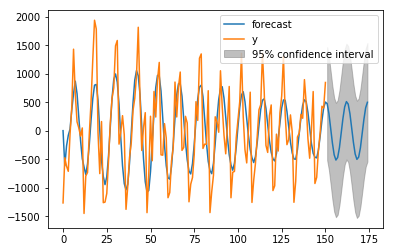

In [181]:
arimaz_trend_stat = ARIMA(Y_trend_stat, order = (2, 0, 2))
model_fit_trend_stat = arimaz_trend_stat.fit(disp = False) # подгоняем под ВР
print(model_fit_trend_stat.summary())
qq = model_fit_trend_stat.plot_predict(0, len(Fort))

                             ARIMA Model Results                              
Dep. Variable:                    D.y   No. Observations:                  150
Model:                ARIMA(11, 1, 0)   Log Likelihood               -1095.740
Method:                       css-mle   S.D. of innovations            343.827
Date:                Mon, 20 May 2019   AIC                           2217.479
Time:                        19:23:57   BIC                           2256.617
Sample:                             1   HQIC                          2233.380
                                                                              
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.4907      2.863      0.171      0.864      -5.121       6.102
ar.L1.D.y     -0.8369      0.056    -14.956      0.000      -0.947      -0.727
ar.L2.D.y     -0.8609      0.052    -16.666      0.0

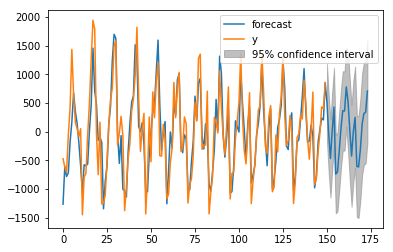

In [183]:
arimaz_trend_stat = ARIMA(Y_trend_stat, order = (11, 1, 0))
model_fit_trend_stat = arimaz_trend_stat.fit(disp = False) # подгоняем под ВР
print(model_fit_trend_stat.summary())
qq = model_fit_trend_stat.plot_predict(1, len(Fort))

Но хотелось бы все же увидеть – как же этот прогноз по АРПСС
модели соотносится с исходными известными 24 прогнозными
точками (ведь прогноз все-таки ретроспективный). Для этого нужно
из исходного ряда Fort тоже вычесть линейный тренд и соотнести их
на одном изображении:

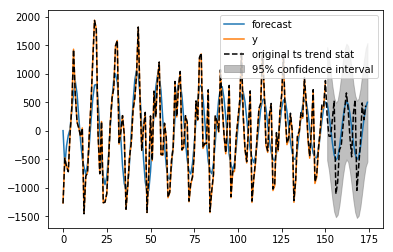

In [171]:
FFort = np.hstack(Fort)
Fort_trend_stat = FFort - func(t0, popt[0], popt[1])
model_fit_trend_stat.plot_predict(0, len(Fort)) # прогноз по АРПСС
plt.plot(t0, Fort_trend_stat, 'k--', label = 'original ts trend stat') # исходный ВР минус тренд
plt.legend()
plt.show()

In [172]:
m_tstat = print_metrics(Fort_trend_stat[-24:], model_fit_trend_stat.predict(len(Y), len(FFort)))
list(zip(metrics_names, m_tstat))

[('MAE__', 373.77),
 ('RMSE_', 468.27),
 ('appr_', 37.438),
 ('coef1', 0.883),
 ('coef2', 0.883)]

## НЕ трендстационарная форма 
Наконец, попробуйте построить АРПСС модель для
прогнозирования данного ряда, но __без исходного вычитания из него
линейного тренда__. Отметьте получившиеся отличия в работе
функций Python и точности конечных результатов.

Аналогично, для данной модели постройте графики прогноза с
доверительными интервалами относительно оригинального ряда Fort,
а также оцените точность прогноза на основе оценок из пункта 11
выше.

In [173]:
find_order_BIC(Y)

(3, 1, 3)

                             ARIMA Model Results                              
Dep. Variable:                    D.y   No. Observations:                  150
Model:                 ARIMA(3, 1, 3)   Log Likelihood               -1170.104
Method:                       css-mle   S.D. of innovations            571.263
Date:                Mon, 20 May 2019   AIC                           2356.208
Time:                        18:33:53   BIC                           2380.293
Sample:                             1   HQIC                          2365.993
                                                                              
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -9.1435      2.513     -3.639      0.000     -14.069      -4.218
ar.L1.D.y      0.5963      0.071      8.407      0.000       0.457       0.735
ar.L2.D.y     -1.0032      0.004   -248.166      0.0

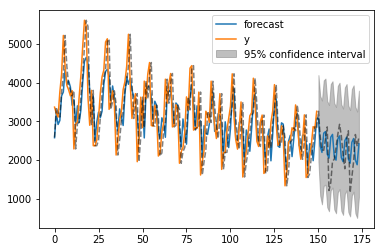

In [178]:
arimaz = ARIMA(Y, order = (3, 1, 3))
model_fit = arimaz.fit(disp = False) # подгоняем под ВР
print(model_fit.summary())
FFort = np.hstack(Fort)
ff = model_fit.plot_predict(1, len(FFort)) # прогноз по АРПСС
plt.plot(t0, FFort, 'k--', alpha=0.5) # исходный ВР минус тренд
plt.show()

In [177]:
m_tstat = print_metrics(FFort[-24:], model_fit_trend_stat.predict(len(Y), len(FFort)))
list(zip(metrics_names, m_tstat))

[('MAE__', 2264.587),
 ('RMSE_', 2314.559),
 ('appr_', 102.581),
 ('coef1', 0.994),
 ('coef2', 4.316)]